In [1]:
import sys
sys.path.insert(0, '../')

import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

from flax import nn
from flax import optim

import tomo_challenge as tc
from tomo_challenge import jax_metrics
from tomo_challenge import metrics

import warnings
warnings.filterwarnings('ignore')

from jax_cosmo.redshift import kde_nz

Found classifier NeuralNetwork
Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [2]:
training_file = "../data/training.hdf5"
validation_file = "../data/validation.hdf5"
bands = "riz"
colors = True
errors = True
array = True

x_train = jnp.array(tc.load_data(training_file, bands, colors=colors, errors=errors, array=array))
z_train = jnp.array(tc.load_redshift(training_file))
x_test = jnp.array(tc.load_data(validation_file, bands, colors=colors, errors=errors, array=array))
z_test = jnp.array(tc.load_redshift(validation_file))

assert len(x_train) == len(z_train)

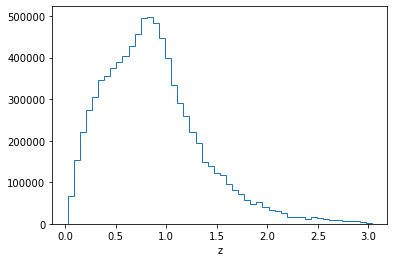

In [3]:
# Plotting redshift distribution
plt.hist(z_train, bins=50, histtype='step')
plt.xlabel('z');

In [4]:
n_bins = 8
class CNN(nn.Module):
    def apply(self, x):
        b = x.shape[0]
        x = nn.Conv(x, features=128, kernel_size=(4,), padding='SAME')
        x = nn.BatchNorm(x)
        x = nn.leaky_relu(x)
        x = nn.avg_pool(x, window_shape=(2,), padding='SAME')
        x = nn.Conv(x, features=256, kernel_size=(4,), padding='SAME')
        x = nn.BatchNorm(x)
        x = nn.leaky_relu(x)
        x = nn.avg_pool(x, window_shape=(2,), padding='SAME')
        x = x.reshape(b, -1)
        x = nn.Dense(x, features=128)
        x = nn.BatchNorm(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(x, features=n_bins)
        x = nn.softmax(x)
        return x

In [5]:
# Initialize model and optimizer
_, initial_params = CNN.init_by_shape(jax.random.PRNGKey(0), [((1, x_train.shape[1], 1), jnp.float32)])
model = nn.Model(CNN, initial_params)

optimizer = optim.Adam(learning_rate=0.001).create(model)

In [6]:
@jax.jit
def train_step(optimizer, batch):
    def loss_fn(model):
        w = model(batch['features'][..., jnp.newaxis])
        return 1. / jax_metrics.compute_fom(w, batch['labels'])
    
    loss, g = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(g)
    return optimizer, loss

In [7]:
batch_size = 5000
def get_batch():
    inds = onp.random.choice(len(z_train), batch_size)
    return {'labels': z_train[inds], 'features': x_train[inds]}

In [ ]:
epochs = 200

losses = []

for epoch in range(epochs):
    batch = get_batch()
    optimizer, loss = train_step(optimizer, batch)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 0.00531146314479478
Epoch: 10, Loss: 0.0005737615185295224
Epoch: 20, Loss: 0.000416075801396998
Epoch: 30, Loss: 0.0003317181615694712


In [ ]:
plt.plot(losses)
plt.yscale('log')

In [ ]:
bs = 10000
s = len(x_test)
weights = jnp.concatenate([optimizer.target(x_test[bs*i:min((bs*(i+1)), s)][..., jnp.newaxis]) for i
                              in range(s//bs + 1)])

assert len(weights) == s
tomo_bin = weights.argmax(axis=-1)

In [ ]:
fig = plt.figure(figsize=(10, 6))
for i in range(n_bins):
    plt.hist(z_test[tomo_bin == i], bins=100, alpha=0.4, label=f'bin {i}')
plt.xlabel('z')
plt.legend();

In [ ]:
jax_metrics.compute_scores(tomo_bin, z_test)